In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage import io
import random
import tqdm
import torch as tc
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, datasets, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, f1_score, classification_report, confusion_matrix, roc_curve, auc, recall_score
import seaborn as sns
! pip install torchsummary
from torchsummary import summary
import gc
from google.colab import drive
import time
import albumentations

In [2]:
drive.mount('/content/drive')
path = "/content/drive/My Drive/Brain_tumor"

path_testing = path + "/crop_square_test"
path_training = path + "/crop_square_train"

list_train = os.listdir(path_training)
list_test = os.listdir(path_testing)
print(list_train)
print(list_test)

Mounted at /content/drive
['no_tumor', 'meningioma_tumor', 'glioma_tumor', 'pituitary_tumor']
['glioma_tumor', 'no_tumor', 'pituitary_tumor', 'meningioma_tumor']


In [3]:
# training dataset 
train_glioma = path_training + "/glioma_tumor"
train_meningioma = path_training + "/meningioma_tumor"
train_no_tumor = path_training + "/no_tumor"
train_pituitary = path_training + "/pituitary_tumor"

print(f'train glioma: {len(os.listdir(train_glioma))}')
print(f'train meningioma: {len(os.listdir(train_meningioma))}')
print(f'train no tumor: {len(os.listdir(train_no_tumor))}')
print(f'train pituitary: {len(os.listdir(train_pituitary))}')

# testing dataset
test_glioma = path_testing + "/glioma_tumor"
test_meningioma = path_testing + "/meningioma_tumor"
test_no_tumor = path_testing + "/no_tumor"
test_pituitary = path_testing + "/pituitary_tumor"

print(f'test glioma: {len(os.listdir(test_glioma))}')
print(f'test meningioma: {len(os.listdir(test_meningioma))}')
print(f'test no tumor: {len(os.listdir(test_no_tumor))}')
print(f'test pituitary: {len(os.listdir(test_pituitary))}')

train glioma: 826
train meningioma: 822
train no tumor: 395
train pituitary: 827
test glioma: 100
test meningioma: 115
test no tumor: 105
test pituitary: 74


In [4]:
class TumorDataset(tc.utils.data.Dataset):
  def __init__(self, image_paths, image_labels, transforms):
    self.image_paths = image_paths
    self.labels = image_labels
    self.transforms = transforms

  def __getitem__(self,i):
    image = plt.imread(self.image_paths[i])
    label = self.labels[i]
    image = self.transforms(image)
    return image, label

  def __len__(self):
    return len(self.image_paths)

def labels(filename, main_path):
    if filename[len(main_path)+1] == "g":
        label = 0
    elif filename[len(main_path)+1] == "m":
        label = 1
    elif filename[len(main_path)+1] == "p":
        label = 2
    else:
        label = 3
    return label

classes = ['Glioma', 'Meningioma', 'Pituitary', 'No Tumor']

In [5]:
train_path = [path_training + '/' + i + '/' + img 
                    for i in os.listdir(path_training) 
                    for img in os.listdir(path_training + '/' + i)
                    ]

test_path = [path_testing + '/' + i + '/' + img 
                  for i in os.listdir(path_testing) 
                  for img in os.listdir(path_testing + '/' + i)
                  ]

transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Resize((224,224)),
                                #transforms.ColorJitter(contrast=(2,2)),
                                #transforms.GaussianBlur(kernel_size=5, sigma=(1, 1)),
                                #transforms.RandomHorizontalFlip(p=1),
                                #transforms.RandomRotation(degrees=90),
                                #transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 5)),
                                #transforms.RandomAdjustSharpness(sharpness_factor=2, p=1),
                                ])

In [6]:
train_label = [labels(data, path_training) for data in train_path]
test_label = [labels(data, path_testing) for data in test_path]

print(f"Train: {len(train_label)}")
print(f"Test: {len(test_label)}")

#Validation dataset 
training_path, validation_path, training_label, validation_label = train_test_split(train_path, train_label, test_size=0.05, random_state = 101, stratify=train_label) 
print(f"Validation: {len(validation_path)}")
print(f"training: {len(training_path)}")

Train: 2870
Test: 394
Validation: 144
training: 2726


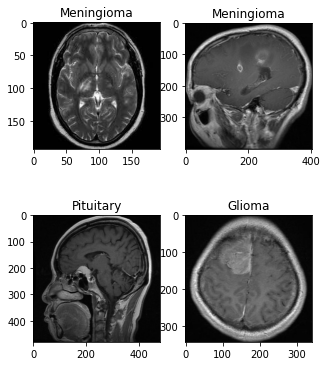

In [7]:
# random image from train Dataset (before resizing)
plt.figure(figsize=(5,6.5))
for i in range(4):
  n = random.randint(0, len(training_path)-1)
  image = plt.imread(training_path[n])
  plt.subplot(2,2,i+1)
  plt.imshow(image)
  plt.title(classes[train_label[n]])
plt.show()

In [8]:
train_dataset = TumorDataset(training_path, training_label, transforms=transform)
test_dataset = TumorDataset(test_path, test_label, transforms=transform)
validation_dataset = TumorDataset(validation_path, validation_label, transforms=transform)

batch_size = 4
num_workers = 2

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)

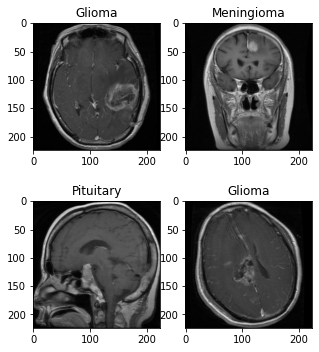

In [9]:
# random image from train DataLoader (after resizing)
plt.figure(figsize=(5,6))
for i in range(4):
  for images, labels in train_dataloader:
    plt.subplot(2,2,i+1)
    plt.imshow(images[0, :, :, :].numpy().swapaxes(0, 1).swapaxes(1, 2))
    plt.title(classes[labels[0]])
    break
plt.show()

In [10]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        tc.nn.init.normal_(m.weight, mean=0, std=0.01)

In [11]:
class FineTuneModel(nn.Module):
    def __init__(self, original_model, num_classes, is_requires_grad = False, is_first_learning = True):
        super(FineTuneModel, self).__init__()

        self.features = original_model.features
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
        self.classifier.apply(init_weights)
        for p in self.features.parameters():
          p.requires_grad = is_requires_grad
          
    
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = tc.flatten(x, 1)
        x = self.classifier(x)
        return x

In [12]:
model = torchvision.models.vgg16(pretrained=True)
model = FineTuneModel(model, 4)
device = "cuda:0"     # or "cpu"
model = model.to(device)    # move the model to GPU
summary(model, input_size=(3, 224, 224))

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [13]:
class EarlyStopping():
    """
    Early stopping to stop the training when the loss does not improve after
    certain epochs.
    """
    def __init__(self, patience=10, min_delta=0):
        """
        :param patience: how many epochs to wait before stopping when loss is
               not improving
        :param min_delta: minimum difference between new loss and old loss for
               new loss to be considered as an improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

In [14]:
def fit(num_epoch, cost_function, optimizer, path):
  train_losses = []
  train_accuracy = []
  eval_losses = []
  eval_accuracy = []
  best_accuracy = 0

  for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0 
    print(f'Epoch: {epoch+1}')

    model.train()
    for image, label in tqdm.tqdm(train_dataloader, position=0, leave=True):  
      image = image.to(device)
      label = label.to(device)

      optimizer.zero_grad()
      results = model(image)
      loss = cost_function(results, label)
      loss.backward()
      optimizer.step()

      running_loss += loss.item()
      _, predicted = results.max(1)
      total += label.size(0)
      correct += predicted.eq(label).sum().item()

    train_loss = running_loss / len(train_dataloader)
    accuracy = 100. * correct / total
    
    train_accuracy.append(accuracy)
    train_losses.append(train_loss)
    print('Train Loss: %.3f | Accuracy: %.3f'%(train_loss, accuracy))


    model.eval()
    with tc.no_grad():
      for image, label in tqdm.tqdm(validation_dataloader, position=0, leave=True):
        
        image = image.to(device)
        label = label.to(device)

        results = model(image)
        val_loss = cost_function(results, label)

        running_val_loss += val_loss.item()
        _, predicted_val = results.max(1)
        total_val += labels.size(0)
        correct_val += predicted_val.eq(label).sum().item()

    val_loss = running_val_loss / len(validation_dataloader)
    accuracy_val = 100. * correct_val / total_val
    if accuracy_val >= best_accuracy:
      tc.save(model.state_dict(), path)
      best_accuracy = accuracy_val

    eval_losses.append(val_loss)
    eval_accuracy.append(accuracy_val)

    print('Validation Loss: %.3f | Accuracy: %.3f'%(val_loss, accuracy_val))

    early_stopping(val_loss)
    if early_stopping.early_stop:
        break

  end = time.time()
  print(f"Training time: {(end-start)/60:.3f} minutes")

  return train_accuracy, eval_accuracy, train_losses, eval_losses

In [15]:
def plot_accuracy(train_accuracy, eval_accuracy):
  plt.plot(train_accuracy,'.-')
  plt.plot(eval_accuracy,'.-')
  plt.xlabel('epoch')
  plt.ylabel('accuracy [%]')
  plt.legend(['Train','Valid'], loc="lower right")
  plt.title("Model accuracy")
  plt.show()

def plot_losses(train_losses, eval_losses):
  plt.plot(train_losses,'.-')
  plt.plot(eval_losses,'.-')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['Train','Valid'])
  plt.title("Model loss")
  plt.show()

In [16]:
def evaluate(model, test_dataloader):
  model.eval()
  actuals = []
  predictions = []

  with tc.no_grad():
    for image, label in test_dataloader:    
      image = image.to(device)                     # GPU
      label = label.to(device)
      results = model(image)             
      prediction = results.argmax(dim=1, keepdim=True)     
      actuals.extend(label.view_as(prediction))        #[]
      predictions.extend(prediction)

  actuals = [i.item() for i in actuals]
  predictions = [i.item() for i in predictions]
  return actuals, predictions

In [17]:
def plot_confusion_matrix(conf_matrix):
  plt.figure(figsize=(7,6))
  sns.heatmap(conf_matrix, xticklabels=classes, yticklabels=['','','',''], annot=True, fmt='.3g',  cmap='YlGnBu')   #Reds
  plt.ylabel('True label \n \n \n   No Tumor           Pituitary          Meningioma          Glioma    ')
  plt.xlabel('\n \n  Predicted label')
  plt.title('Confusion matrix')
  plt.show()

In [18]:
def class_probabilities(model, number_of_class):
  model.eval()
  actuals = []
  probabilities = []
  with tc.no_grad():
    for image, label in test_dataloader:
      image = image.to(device)
      label = label.to(device)
      results = model(image)
      prediction = results.argmax(dim=1, keepdim=True)
      actuals.extend(label.view_as(prediction) == number_of_class)
      probabilities.extend(np.exp(results.cpu()[:, number_of_class]))

  actuals = [i.item() for i in actuals]
  probabilities = [i.item() for i in probabilities]
  
  fpr, tpr, _ = roc_curve(actuals, probabilities)
  roc_auc = auc(fpr, tpr)

  return fpr, tpr, roc_auc

In [19]:
optimizer = tc.optim.Adam(model.parameters(), lr=0.0001)
cost_function = nn.CrossEntropyLoss()
num_epochs = 3
path = '/content/drive/My Drive/Brain_tumor/model/train_only_classification_layers.pth'

early_stopping = EarlyStopping()
start = time.time()

train_accuracy, eval_accuracy, train_losses, eval_losses = fit(num_epochs, cost_function, optimizer, path)

Epoch: 1


100%|██████████| 682/682 [15:07<00:00,  1.33s/it]


Train Loss: 0.776 | Accuracy: 73.514


100%|██████████| 36/36 [00:45<00:00,  1.27s/it]


Validation Loss: 0.523 | Accuracy: 76.389
Epoch: 2


100%|██████████| 682/682 [02:45<00:00,  4.12it/s]


Train Loss: 0.353 | Accuracy: 87.601


100%|██████████| 36/36 [00:05<00:00,  6.10it/s]


Validation Loss: 0.480 | Accuracy: 81.250
Epoch: 3


100%|██████████| 682/682 [02:45<00:00,  4.11it/s]


Train Loss: 0.209 | Accuracy: 92.480


100%|██████████| 36/36 [00:06<00:00,  5.92it/s]


Validation Loss: 0.518 | Accuracy: 86.806
INFO: Early stopping counter 1 of 10
Training time: 21.842 minutes


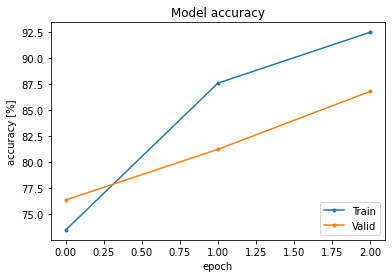

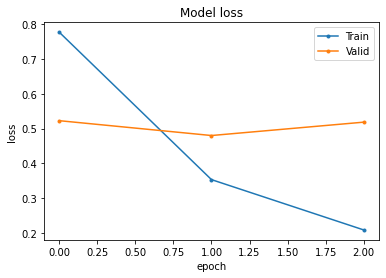

In [20]:
plot_accuracy(train_accuracy, eval_accuracy)
plot_losses(train_losses, eval_losses)

In [21]:
#model.load_state_dict(tc.load(path))
actuals, predictions = evaluate(model, test_dataloader)

cm = confusion_matrix(actuals, predictions)
print("Confusion Matrix : ")
print(cm)
print('Recall score: %f' % recall_score(actuals, predictions, average='macro'))
print('Precision score: %f' % precision_score(actuals, predictions, average='macro'))
print('Accuracy score: %f' % accuracy_score(actuals, predictions))
print('F1 score: %f' % f1_score(actuals, predictions, average='macro'))
print(classification_report(actuals, predictions)) 

Confusion Matrix : 
[[ 47  20   4  29]
 [  8  94   5   8]
 [  0   0  64  10]
 [  1   0   1 103]]
Recall score: 0.783302
Precision score: 0.803845
Accuracy score: 0.781726
F1 score: 0.774058
              precision    recall  f1-score   support

           0       0.84      0.47      0.60       100
           1       0.82      0.82      0.82       115
           2       0.86      0.86      0.86        74
           3       0.69      0.98      0.81       105

    accuracy                           0.78       394
   macro avg       0.80      0.78      0.77       394
weighted avg       0.80      0.78      0.77       394



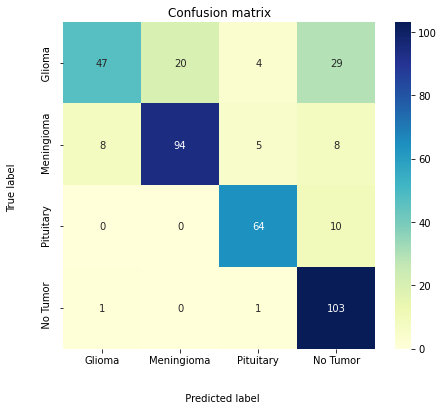

In [22]:
plot_confusion_matrix(cm)

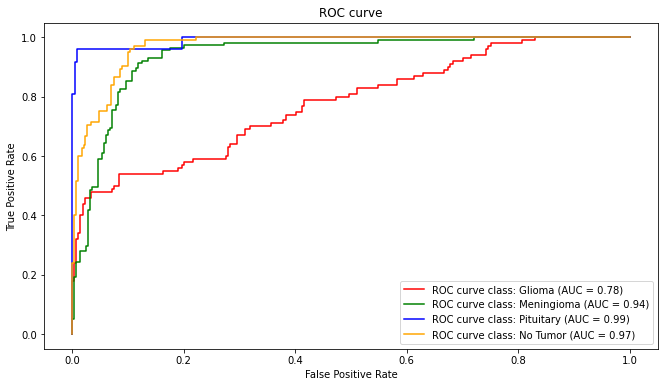

In [23]:
fpr_dict ={}
tpr_dict = {}
roc_auc_dict = {}
for i in range(4):
  fpr, tpr, roc_auc = class_probabilities(model, i)
  fpr_dict[i] = fpr
  tpr_dict[i] = tpr
  roc_auc_dict[i] = roc_auc

colors = ['r', 'g', 'b', 'orange']

plt.figure(figsize=[11,6])
for i in range(4):
  plt.plot(fpr_dict[i], tpr_dict[i], color = colors[i], label='ROC curve class: ' + classes[i] + ' (AUC = %0.2f)' % roc_auc_dict[i])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title("ROC curve")

plt.show()

In [24]:
model = torchvision.models.vgg16(pretrained=False)
model = FineTuneModel(model, 4, True)
model.load_state_dict(tc.load(path))
device = "cuda:0"     # or "cpu"
model = model.to(device)    # move the model to GPU
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [25]:
optimizer = tc.optim.Adam(model.parameters(), lr=0.00001)
cost_function = nn.CrossEntropyLoss()
num_epochs = 50
path = '/content/drive/My Drive/Brain_tumor/model/train_only_classification_layers+train_all_model.pth'

train_accuracy, eval_accuracy, train_losses, eval_losses = fit(num_epochs, cost_function, optimizer, path)

Epoch: 1


100%|██████████| 682/682 [04:36<00:00,  2.46it/s]


Train Loss: 0.126 | Accuracy: 95.818


100%|██████████| 36/36 [00:06<00:00,  5.91it/s]


Validation Loss: 0.189 | Accuracy: 91.667
Epoch: 2


100%|██████████| 682/682 [04:37<00:00,  2.46it/s]


Train Loss: 0.037 | Accuracy: 98.679


100%|██████████| 36/36 [00:05<00:00,  6.06it/s]


Validation Loss: 0.390 | Accuracy: 88.889
INFO: Early stopping counter 2 of 10
Epoch: 3


100%|██████████| 682/682 [04:37<00:00,  2.46it/s]


Train Loss: 0.019 | Accuracy: 99.413


100%|██████████| 36/36 [00:06<00:00,  5.84it/s]


Validation Loss: 0.252 | Accuracy: 93.750
INFO: Early stopping counter 3 of 10
Epoch: 4


100%|██████████| 682/682 [04:37<00:00,  2.46it/s]


Train Loss: 0.021 | Accuracy: 99.303


100%|██████████| 36/36 [00:05<00:00,  6.09it/s]


Validation Loss: 0.323 | Accuracy: 92.361
INFO: Early stopping counter 4 of 10
Epoch: 5


100%|██████████| 682/682 [04:37<00:00,  2.46it/s]


Train Loss: 0.027 | Accuracy: 99.083


100%|██████████| 36/36 [00:06<00:00,  5.97it/s]


Validation Loss: 0.167 | Accuracy: 94.444
Epoch: 6


100%|██████████| 682/682 [04:37<00:00,  2.46it/s]


Train Loss: 0.002 | Accuracy: 99.963


100%|██████████| 36/36 [00:05<00:00,  6.12it/s]


Validation Loss: 0.278 | Accuracy: 93.750
INFO: Early stopping counter 5 of 10
Epoch: 7


100%|██████████| 682/682 [04:36<00:00,  2.47it/s]


Train Loss: 0.000 | Accuracy: 100.000


100%|██████████| 36/36 [00:06<00:00,  5.91it/s]


Validation Loss: 0.282 | Accuracy: 95.833
INFO: Early stopping counter 6 of 10
Epoch: 8


100%|██████████| 682/682 [04:37<00:00,  2.46it/s]


Train Loss: 0.000 | Accuracy: 100.000


100%|██████████| 36/36 [00:05<00:00,  6.07it/s]


Validation Loss: 0.309 | Accuracy: 94.444
INFO: Early stopping counter 7 of 10
Epoch: 9


100%|██████████| 682/682 [04:36<00:00,  2.47it/s]


Train Loss: 0.000 | Accuracy: 100.000


100%|██████████| 36/36 [00:05<00:00,  6.13it/s]


Validation Loss: 0.312 | Accuracy: 95.139
INFO: Early stopping counter 8 of 10
Epoch: 10


100%|██████████| 682/682 [04:36<00:00,  2.47it/s]


Train Loss: 0.000 | Accuracy: 100.000


100%|██████████| 36/36 [00:05<00:00,  6.06it/s]


Validation Loss: 0.356 | Accuracy: 93.750
INFO: Early stopping counter 9 of 10
Epoch: 11


100%|██████████| 682/682 [04:36<00:00,  2.47it/s]


Train Loss: 0.000 | Accuracy: 100.000


100%|██████████| 36/36 [00:05<00:00,  6.11it/s]

Validation Loss: 0.416 | Accuracy: 94.444
INFO: Early stopping counter 10 of 10
INFO: Early stopping
Training time: 77.185 minutes


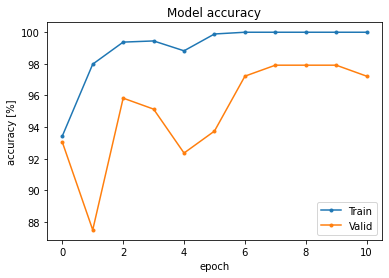

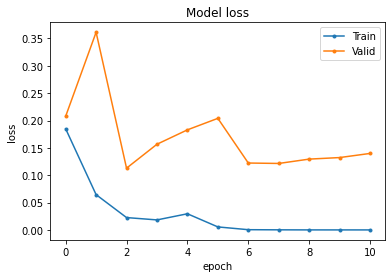

In [ ]:
plot_accuracy(train_accuracy, eval_accuracy)
plot_losses(train_losses, eval_losses)

In [26]:
model.load_state_dict(tc.load(path))
actuals, predictions = evaluate(model, test_dataloader)

cm = confusion_matrix(actuals, predictions)
print("Confusion Matrix : ")
print(cm)
print('Recall score: %f' % recall_score(actuals, predictions, average='macro'))
print('Precision score: %f' % precision_score(actuals, predictions, average='macro'))
print('Accuracy score: %f' % accuracy_score(actuals, predictions))
print('F1 score: %f' % f1_score(actuals, predictions, average='macro'))
print(classification_report(actuals, predictions)) 

Confusion Matrix : 
[[ 39  41   0  20]
 [  2 112   0   1]
 [  0   1  60  13]
 [  0   0   0 105]]
Recall score: 0.793681
Precision score: 0.858472
Accuracy score: 0.802030
F1 score: 0.785521
              precision    recall  f1-score   support

           0       0.95      0.39      0.55       100
           1       0.73      0.97      0.83       115
           2       1.00      0.81      0.90        74
           3       0.76      1.00      0.86       105

    accuracy                           0.80       394
   macro avg       0.86      0.79      0.79       394
weighted avg       0.84      0.80      0.78       394



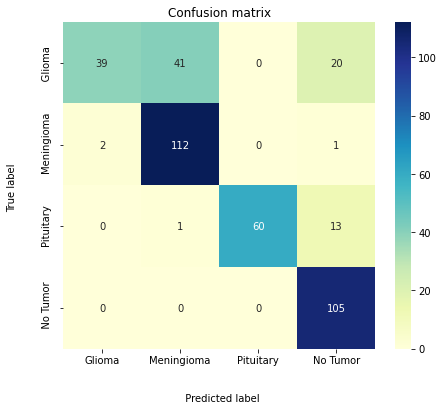

In [27]:
plot_confusion_matrix(cm)

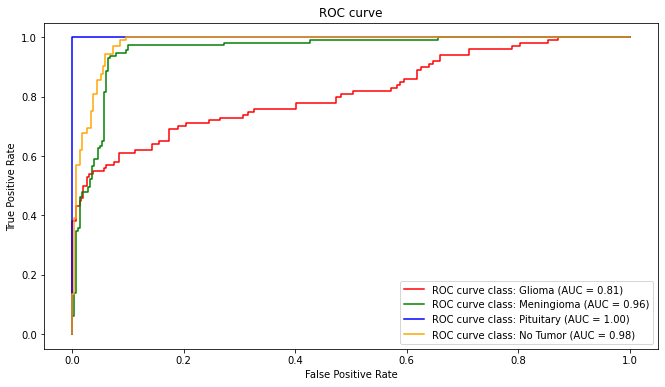

In [28]:
fpr_dict ={}
tpr_dict = {}
roc_auc_dict = {}
for i in range(4):
  fpr, tpr, roc_auc = class_probabilities(model, i)
  fpr_dict[i] = fpr
  tpr_dict[i] = tpr
  roc_auc_dict[i] = roc_auc

colors = ['r', 'g', 'b', 'orange']

plt.figure(figsize=[11,6])
for i in range(4):
  plt.plot(fpr_dict[i], tpr_dict[i], color = colors[i], label='ROC curve class: ' + classes[i] + ' (AUC = %0.2f)' % roc_auc_dict[i])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title("ROC curve")

plt.show()